In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")
from numba import njit, prange

## Function definition

In [2]:
# Speed function
def V(x): 
    if isinstance(x,list):
        return [np.square(1-i/4500)*9.78 for i in x]
    else:
        return np.square(1-x/4500)*9.78

# Event-based simulation, reffering to Algorithm 1 in the paper
def within_day_process(Departure_time,trip_len,Number_of_user):
    # Step 1
    n=0 # Number of vehicle (accumulation)
    j=0 # index of event
    t=[] # event time
    vehicle_index=[]
    Accumulation=[]
    Speed=[]
    
    # Predicted arrival time
    Arrival_time=Departure_time+trip_len/9.78/60
    
    # Step 2
    # Define event list of departures
    
    Event_list1_array=np.zeros((Number_of_user,4))
    Event_list1_array[:,0]=np.arange(Number_of_user) # vehicle index
    Event_list1_array[:,1]=Departure_time # time(min)
    Event_list1_array[:,2]=np.ones(Number_of_user) # departure indicator: 1
    Event_list1_array[:,3]=trip_len # trip length
    
    # Define event list of arrivals
    Event_list2_array=np.zeros((Number_of_user,4))
    Event_list2_array[:,0]=np.arange(Number_of_user) # vehicle index
    Event_list2_array[:,1]=Arrival_time # time(min)
    Event_list2_array[:,2]=np.ones(Number_of_user)*2 # arrival indicator: 2
    Event_list2_array[:,3]=trip_len # trip length

    # S_Event_list_array: 4 columns
    # vehicle_index  time(min)  event_indicator  trip_len

    # Concatenate these two event lists
    S_Event_list_array=np.concatenate((Event_list1_array, Event_list2_array), axis=0)
    
    # Sort the list by time in ascending order
    S_Event_list_array=S_Event_list_array[S_Event_list_array[:, 1].argsort()]
    
    # get time of the first event
    t.append(S_Event_list_array[0,1]) #initial time
    
    # create a dict to store the information of each agent
    vehicle_information = {}
    vehicle_information['vehicle']=np.arange(Number_of_user)
    vehicle_information['trip_len(m)']=trip_len
    vehicle_information['t_exp']=np.zeros(Number_of_user)
    vehicle_information['account']=np.zeros(Number_of_user)
    
    #Step 3
    # Event-based simulation
    while S_Event_list_array.shape[0]>0:
        j=j+1
        t.append(S_Event_list_array[0,1]) # record the time of the event
        if S_Event_list_array[0,2]==1:     
            vehicle_index.append(int(S_Event_list_array[0,0])) # record the agent that starts the trip

            # update the untraveled trip length
            trip_len1=vehicle_information['trip_len(m)'].to_numpy()
            trip_len1[vehicle_index[0:-1]]=trip_len1[vehicle_index[0:-1]]-V(n)*60*(t[j]-t[j-1])
            vehicle_information['trip_len(m)']=trip_len1

            # update the accumulation in the network
            n=n+1
            
            # keep track of the accumulation
            Accumulation.append(n)
            
            # update the predicted arrival time
            temp=S_Event_list_array[(np.where((S_Event_list_array[:,2]==2) & (np.isin(S_Event_list_array[:,0],vehicle_index[0:-1])==True)))][:,0]
            if np.size(temp)==0:
                temp = np.array([])
            S_Event_list_array[(np.where((S_Event_list_array[:,2]==2) & (np.isin(S_Event_list_array[:,0],vehicle_index[0:-1])==True))),1]=\
            t[j]+vehicle_information['trip_len(m)'][temp.astype(int)]/V(n)/60

        else: #arrival
            # update the trip length
            trip_len1=vehicle_information['trip_len(m)'].values
            trip_len1[vehicle_index]=trip_len1[vehicle_index]-V(n)*60*(t[j]-t[j-1])
            vehicle_information['trip_len(m)']=trip_len1

            # update the accumulation in the network
            n=n-1
            
            # keep track of the accumulation
            Accumulation.append(n)

            # update t_exp
            vehicle_information['t_exp'][int(S_Event_list_array[0,0])]=S_Event_list_array[0,1]-Departure_time[int(S_Event_list_array[0,0])]

            # remove the agent that finishes the trip
            vehicle_index.remove(int(S_Event_list_array[0,0]))
        
            # Update the predicted arrival time
            temp=S_Event_list_array[(np.where((S_Event_list_array[:,2]==2) & (np.isin(S_Event_list_array[:,0],vehicle_index)==True)))][:,0]
            if np.size(temp)==0:
                temp = np.array([])
            S_Event_list_array[(np.where((S_Event_list_array[:,2]==2) & (np.isin(S_Event_list_array[:,0],vehicle_index)==True))),1]=\
            t[j]+vehicle_information['trip_len(m)'][temp.astype(int)]/V(n)/60

        # remove event from the list
        S_Event_list_array = np.delete(S_Event_list_array, (0), axis=0)    
        S_Event_list_array=S_Event_list_array[S_Event_list_array[:, 1].argsort()]
        # update speed with Speed.function
        Speed.append(V(n))
    vehicle_information['t_dep']=Event_list1_array[:,1]
    vehicle_information['t_arr']=vehicle_information['t_dep']+vehicle_information['t_exp']
    time_list=np.concatenate((vehicle_information['t_dep'], vehicle_information['t_arr']), axis=0)
    time_list=time_list=np.sort(time_list,axis=None)
    return vehicle_information, time_list, Accumulation, Speed


def rearrange(df, cols):
    
    all_values=[]
    for idx,i in enumerate(cols):
        
        vals=df[i].T[idx].values
        all_values.append(vals)
    
    if len(cols[0])>1:
        return pd.DataFrame(data=np.vstack(all_values),columns=('t'+str(i) for i in range(2*tao+1)))
    else:
        return pd.DataFrame(data=np.vstack(all_values))
    

def schedule_delay(T_diff):
    SD=np.empty((Number_of_user,2*tao+1))
    for i in range(2*tao+1):
        SD[:,i]=L*T_diff[:,i]*(1-np.array(T_diff[:,i]<0).astype(int))-\
        E*T_diff[:,i]*np.array(T_diff[:,i]<0).astype(int)
    return SD

@njit
def column_generate(time_slot,case='all'):
    columns=[]
    if case=='all':
        for i in range(Number_of_user):
            columns.append([j for j in range(np.sum(time_slot[i]<Departure_time[i])-tao,\
                                                      np.sum(time_slot[i]<Departure_time[i])+tao+1)])
    elif case=='chosen':
        for i in range(Number_of_user):
            columns.append([np.sum(time_slot[i]<Departure_time[i])])
    return columns


@njit
def V1(x):
    return np.square(1-x/4500)*9.78

In [3]:
# Compute the expected (texp) travel time at unchosen departure time point using fictional travelers

# First, create a function to compute the expected tt at a given departure time point
# In a nutshell, we need to compute the speeds of the MFD (time varying) while the fictinoal dirver travels the network, given its trip length. We then can obtain the travel time.
# These speeds can change as they are function 

@njit
def fic_tt(user, time_point, all_time_matrix, new_timelist, trip_len, Accumulation,Number_of_user):
    
    # get the fictional departure time for the fictional traveler
    star_time=all_time_matrix[user,time_point]
    
    # get the list of events happening after this given departure time point to simulate the expected states
    known_list=new_timelist[new_timelist>star_time]
    
    if len(known_list)==0: # if this fictional departure happens after all real travelers
        # exit the network assuming free flow speed (9.78)
        texp=trip_len[user]/9.78/60
    elif len(known_list)==Number_of_user*2: # this fictional departure happens before all real travelers enter the network
        # compute the left trip length till the first real traveler enter the network
        texp=0
        count=0
        left_len=trip_len[user]-9.78*60*(known_list[0]-star_time)
        
        if left_len<0: # if this fictional traveler end his trip before the first real traveler enter the network
            # exit the network assuming free flow speed (9.78)
            texp=trip_len[user]/9.78/60
            
        else: # compute travel speed in each time interval between two consecutive events
            V_list=np.array([V1(x) for x in Accumulation[Number_of_user*2-len(known_list):-1]])
            len_piece=np.diff(known_list)*V_list*60 # trip length traveled in each time interval between two consecutive events
            cum_len=np.cumsum(len_piece)
            count=np.sum(cum_len<left_len)
            texp=known_list[count+1]-star_time+(left_len-cum_len[count])/V1(Accumulation[count])/60
    else: # it means this fictional departure happens after some real travelers have entered the network
        texp=0
        count=0
        # compute the left trip length till the next closest event occurs (either a departure or arrival)
        left_len=trip_len[user]-V1(Accumulation[Number_of_user*2-len(known_list)-1])*(known_list[0]-star_time)*60
        if left_len<0: # if this fictional traveler end his trip before the next real event occurs
            texp=trip_len[user]/V1(Accumulation[Number_of_user*2-len(known_list)-1])/60
        else:
            # travel speed in each time interval between two consecutive events
            V_list=np.array([V1(x) for x in Accumulation[Number_of_user*2-len(known_list):-1]])
            
            # trip length traveled in each time interval between two consecutive events
            len_piece=np.diff(known_list)*V_list*60
            cum_len=np.cumsum(len_piece)
            count=np.sum(cum_len<left_len)
            if count==0:
                texp=known_list[count]-star_time+(left_len-(known_list[count]-star_time)*V1(1))/9.78/60
            elif count==len(cum_len): # this fictional traveler's is not finished even after all real travelers finish their trips
                texp=known_list[count]-star_time+(left_len-cum_len[count-1])/9.78/60
            else: # this fictional traveler finishes the trip before all real travelers finish their trips
                texp=known_list[count+1]-star_time+(left_len-cum_len[count])/V1(Accumulation[Number_of_user*2-len(known_list)+count])/60
    return texp

# Then we use the following function to store the fictional tt for every possible departure times
@njit(parallel=True)
def T_est(all_time_matrix, new_timelist, trip_len, Accumulation, Number_of_user, tao):
    T_estimate_array=np.zeros((Number_of_user,2*tao+1))
    for i in prange(Number_of_user):
        for j in prange(2*tao+1):
            T_estimate_array[i,j]=fic_tt(i, j, all_time_matrix, new_timelist, trip_len, Accumulation,Number_of_user)
    return T_estimate_array

## Parameter settings

(array([  8.,  14.,  29.,  58.,  92., 177., 288., 381., 416., 457., 509.,
        414., 354., 220., 130.,  87.,  38.,  18.,   8.,   2.]),
 array([ 22.89308582,  28.77357215,  34.65405848,  40.5345448 ,
         46.41503113,  52.29551745,  58.17600378,  64.05649011,
         69.93697643,  75.81746276,  81.69794909,  87.57843541,
         93.45892174,  99.33940806, 105.21989439, 111.10038072,
        116.98086704, 122.86135337, 128.74183969, 134.62232602,
        140.50281235]),
 <a list of 20 Patch objects>)

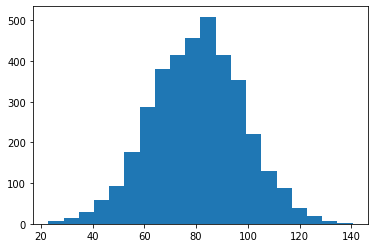

In [4]:
np.random.seed(seed=59)
tao=30 # number of time intervals
Number_of_user=3700

# Generate the inital distributions for departure time
Departure_time=np.random.normal(80,18,Number_of_user)
for i in range(len(Departure_time)):
    if Departure_time[i]<20 or Departure_time[i]>150:
        Departure_time[i]=np.random.normal(80,18,1)
plt.hist(Departure_time,bins=20)

In [5]:
trip_len=np.array(np.zeros(Number_of_user))
for i in range(Number_of_user):
    trip_len[i]=4600+np.random.normal(0,(0.02*4600)**2)
    while trip_len[i]<20:
        trip_len[i]=4600+np.random.normal(0,(0.02*4600)**2)

# Generate the sde and sdl
E=np.array(np.zeros(Number_of_user)) # schedule delay early penalty
L=np.array(np.zeros(Number_of_user)) # schedule delay late penalty
        
Wished_Arrival_time=Departure_time+trip_len/9.78/60 # wished arrival time

for i in range(Number_of_user):
    E[i]=0.5+np.random.normal(0.05**2,0.1**2)
    L[i]=4+np.random.normal(0.1**2,0.4**2)
    while E[i]<0.3 or E[i]>0.7:
        E[i]=0.5+np.random.normal(0.05**2,0.1**2)
    while L[i]<2.5 or L[i]>5.5:
        L[i]=4+np.random.normal(0.1**2,0.4**2)

# departure time choice set 
Dep_time_set=pd.DataFrame()
for i in range(2*tao+1):
    Dep_time_set['t'+str(i)]=Departure_time-tao+i

In [6]:
params={'A': 11, 'mu': 80, 'sigma': 18}
x=np.linspace(-10,130,500)

# toll profile
def custgauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)
toll_profile=custgauss(x,**params)

In [7]:
Sim_day=50
omega=0.7 # Learning rate
norm_list=[] # record the changes of the norm, which is the indicator of the consistency
Acc_df=pd.DataFrame() # record the accumulation on each day
time_label=pd.DataFrame() # time points of the events on each day
all_time_slot=pd.DataFrame()
cost_list=[] # generalized cost, including cost of travel time, schedule delay and credit payment
cs_list=[]
alpha=1.1 # value of time
k=0.0002 # trip length scale factor
tt=[]
Eachday_dep=pd.DataFrame()
Eachday_dep['d0']=Departure_time
theta=5*10**(-1) #scale parameter
util_rand = np.random.gumbel(-0.57721 / theta, 1.0 / theta, (Number_of_user,2*tao+1))
ur=pd.DataFrame(util_rand,columns=('t'+str(i) for i in range(2*tao+1)))

for i in range(2*tao+1):
    all_time_slot['t'+str(i)]=Departure_time-tao+i

all_time_matrix=np.array(all_time_slot)
utility={} # record the random utility of each departure time choice on each day

# choose a case to simulate
Base_Case=False
CP_Case=True
if Base_Case:
    price=np.ones(1)*0 # initial price as 0
elif CP_Case:
    price=np.ones(1)*1 # initial price as 1
    
# For CP_case, it's better to start with the equilibrium state of the base case,
# i.e., run the base case first, store the departure time of the last day, and use it as the starting point.
# Departure_time=np.load('Deptime.npy')

## Main simulation

In [ ]:
for d in range(Sim_day):
    start=time.time()
    # record the output at each day
    vehicle_information, time_list, Accumulation, Speed=within_day_process(Departure_time,trip_len,Number_of_user)

    Acc_df['d'+str(d)]=Accumulation
    time_label['d'+str(d)]=time_list
    vehicle_information['origin_tl']=trip_len

    tt.append(vehicle_information['t_exp'])
    
    new_timelist=time_list
    
    # compute the estimated travel time at unchosen departure time points
    T_estimate=T_est(all_time_matrix, new_timelist, trip_len, Accumulation, Number_of_user, tao)
    T_estimated=pd.DataFrame(T_estimate,columns=('t'+str(i) for i in range(2*tao+1)))

    T_estimated_diff=pd.DataFrame()
    for j in range(2*tao+1):
        T_estimated_diff['t'+str(j)]=T_estimated['t'+str(j)]+all_time_slot['t'+str(j)]-Wished_Arrival_time
    
    # compute the deviation of between the actual (or estimated) arrival time and the wished arrival time
    T_diff=np.array(T_estimated_diff)
    # compute the schedule delay
    SD=schedule_delay(T_diff)
    
    # compute the generalized cost and travel cost, respectively
    c_estimated=pd.DataFrame(columns=('t'+str(i) for i in range(2*tao+1)))
    c_cs=pd.DataFrame(columns=('t'+str(i) for i in range(2*tao+1)))
    for j in range(2*tao+1):
        c_estimated['t'+str(j)]=alpha*T_estimated['t'+str(j)]+SD[:,j]+\
        price[d]*custgauss(all_time_slot['t'+str(j)],**params)*np.array(vehicle_information['origin_tl'])*k

        c_cs['t'+str(j)]=alpha*T_estimated['t'+str(j)]+SD[:,j]

    # update the consumer surplus using historical information
    if d==0:
        c_perceived=c_cs
    else:
        c_perceived=omega*c_perceived+(1-omega)*c_cs
    
    # compute the convergence indicator: the L1 norm
    norm_list.append(np.linalg.norm(c_perceived-c_cs,ord=1)/Number_of_user)

    if Base_Case:
        price=np.append(price,0)
    elif CP_Case:
        price=np.append(price,1)
    
    window_c_perceived=c_perceived
    
    columns1=[]
    for i in range(Number_of_user):
        columns1.append(['t'+str(np.sum(all_time_slot.iloc[i].values<Departure_time[i]))])
    window_c_exp=rearrange(df=c_estimated,cols=columns1)
    window_cs=rearrange(df=c_cs,cols=columns1)

    cost_list.append(window_c_exp.sum()) # generalized cost: tt cost + sd cost + credit payment (or pricing payment)
    cs_list.append(window_cs.sum()) # travel cost: tt cost + sd cost
    
    utility_exp=-window_c_perceived+util_rand
    for j in range(2*tao+1):
        utility_exp['t'+str(j)]=utility_exp['t'+str(j)]-price[d]*custgauss(all_time_slot['t'+str(j)],**params)*np.array(vehicle_information['origin_tl'])*k
    Departure_time=np.diag(Dep_time_set[utility_exp.idxmax(axis=1)])
    utility['d'+str(d)]=np.diag(ur[utility_exp.idxmax(axis=1)])
    
    Eachday_dep['d'+str(d+1)]=Departure_time
    end = time.time()
    print('day',d,':',end-start,cost_list[d][0],cs_list[d][0],price[d])

day 0 : 69.20990896224976 410550.4654600349 359138.59123184375 1.0


## Output

### Computation of generalized cost, travel cost, consumer surplus, social welfare and random utility

In [ ]:
gc=np.zeros(Sim_day) # generalized cost
tc=np.zeros(Sim_day) # travel cost
for i in range(Sim_day):
    gc[i]=cost_list[i][0]
    tc[i]=cs_list[i][0]
    
csu=np.zeros(Sim_day) # consumer surplus
sw=np.zeros(Sim_day) # social welfare
for i in range(Sim_day):
    csu[i]=-gc[i]+np.sum(utility['d'+str(i)])
    sw[i]=-tc[i]+np.sum(utility['d'+str(i)])
    
ttt=np.zeros(Sim_day) # travel time
for i in range(Sim_day):
    ttt[i]=sum(tt[i])

In [ ]:
print('ttc mean:',np.mean(ttt[Sim_day-10:]/Number_of_user))
print('ttc std:',np.std(ttt[Sim_day-10:]/Number_of_user))
print('sd mean:',np.mean(tc[Sim_day-10:]/Number_of_user-ttt[Sim_day-10:]/Number_of_user))
print('sd std:',np.std(tc[Sim_day-10:]/Number_of_user-ttt[Sim_day-10:]/Number_of_user))
print('ru mean:',np.mean(sw[Sim_day-10:]+tc[Sim_day-10:])/Number_of_user)
print('ru std:',np.std((sw[Sim_day-10:]+tc[Sim_day-10:])/Number_of_user))
print('cs mean:',np.mean(csu[Sim_day-10:]/Number_of_user))
print('cs std:',np.std(csu[Sim_day-10:]/Number_of_user))
print('sw mean:',np.mean(sw[Sim_day-10:]/Number_of_user))
print('sw std:',np.std(sw[Sim_day-10:]/Number_of_user))

### Visualization

#### Evolution of inconsistency

In [ ]:
plt.plot(range(1,Sim_day),norm_list[1:],color='red')
plt.xlabel('Days')
plt.ylabel('$|C_d-c_d|_1$/$N$ [DKK]')

#### Evolution of consumer surplus

In [ ]:
plt.plot(range(0,Sim_day),csu[0:]/Number_of_user,color='red')
ax2.set_xlabel('Days')
ax2.set_ylabel('Average consumer surplus [DKK]')

#### Evolution of social welfare

In [ ]:
plt.plot(range(0,Sim_day),sw[0:]/Number_of_user,color='red')
plt.xlabel('Day')
plt.ylabel('$W_{TCS}$ [DKK]')

#### Evolution of accumulation

In [ ]:
x=np.linspace(0,180,500) # ploting scale
toll_profile=custgauss(x,**params)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# a4,=ax2.plot(x,toll_profile,linestyle='--',color='gray') # uncommented when ploting the toll profile together
a1,=ax1.plot(time_label['d0'],Acc_df['d0'], color='red')
# a2,=ax1.plot(time_label['d10'],Acc_df['d10'], color='orange') # uncommented when ploting accumulation curve of another day
a3,=ax1.plot(time_label['d35'],Acc_df['d35'], color='green')
a5,=ax1.plot(time_label['d49'],Acc_df['d49'], color='blue')

# plt.legend([a1,a3,a5,a4], ['day 0','day 35','day 49','Toll profile'])
plt.legend([a1,a3,a5,a4], ['day 0','day 35','day 49'])
ax1.set_xlabel('Time [min]')
ax1.set_ylabel('Accumulation [traveler]')
# ax2.set_ylabel('Credit charge',color='gray')